The complete equation of the cyber-physical system is as follows:

<img src="FullEquation.PNG">

For the purposes of this code however, we neglect the attack on actuators and also neglect the control law. Therefore the equation used will be as follows:

<img src="InitialEquation.PNG">

where e(t) is the attack vector. We try to correctly estimate the state matrix x(t) despite the compromised sensor readings.

We will take A as a 25x25 sized real matrix. The number of sensors will be taken as 20. Therefore C is a 20x25 real valued matrix. The values will be gaussian distributed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def SpectralRadiusNormalized(A):
    return A / np.amax(np.absolute(np.linalg.eigvals(A)))

def GradientDescent(A,C,Y,T,P,N,iterations=10000, learning_rate=0.01):
    
    K = np.zeros((T, P, N))  # Variable needed for computing gradient
    K[0,:,:] = C
    for i in range(1, T):
        K[i,:,:] = np.matmul(C , A ** i)  # size is p * n
    
    x = np.zeros((N, 1))  # initial guess
    for i in range(0, iterations):
        x = x - (learning_rate * GradientMatrix(K,x,Y,N,P,T))
    return x
    
def GradientMatrix(K,x,Y,N,P,T):
    
    delLoss = np.zeros((N, 1))  # the gradient
    I  = np.zeros((T,P,N))   # (T,P,N)
    M  = np.matmul(K,x) - Y  # (T,P,1)
    Mp = (np.sum(M**2, axis = 0)) ** -0.5  # (P,1)
    
    for n in range(0, N):
        I[:,:,n] = K[:,:,n] * M[:,:,0]
        
    It = np.sum(I, axis = 0)  # (P,N)
    delLoss[:,0] = np.sum(It * Mp, axis = 0)
    
    return delLoss

def Full(N,P,T,q,errormean=0,errordeviation=2,mean=0,deviation=2):
    
    A = SpectralRadiusNormalized(np.random.normal(mean, deviation, (N, N)))
    C = np.random.normal(mean, deviation, (P, N))
    X = np.random.normal(mean, deviation, (T, N, 1))  # State Matrix
    E = np.random.normal(errormean, errordeviation, (T, P, 1))  # Error Vector
    Y = np.random.normal(mean, deviation, (T, P, 1))  # Output Matrix
    
    Y[0,:,:] = np.matmul(C , X[0,:,:])
    
    for i in range(1, T):
        X[i,:,:] = np.matmul(A ** i , X[0,:,:])
        Y[i,:,:] = np.matmul(C , X[i,:,:])
        
    E[:, q: ,:] = 0
    Y = np.matmul(C, X) + E
    x = GradientDescent(A,C,Y,T,P,N,1000,0.001)
    
    error = []
    for n in range(0, N):
        error.append(float((x[n] - X[0,n,:])/x[n]))
    
    return np.asarray(error)

In [3]:
N = 25   # Size of A
P = 20   # No. of sensors
T = 15    # Time Steps
thresholderror = 0.07
averagecorrectstates = 0
plotting = []

for q in range(0, P+1):  # q is number of sensors compromised

    iterations = 100
    correctstatesarray = np.zeros(N)

    for i in range(0, iterations):
        correctstates = np.size(np.where(np.absolute(Full(N,P,T,q,0,1,0,1)) < thresholderror))
        averagecorrectstates = (i * averagecorrectstates + correctstates)/(i+1)
    
    plotting.append(averagecorrectstates)


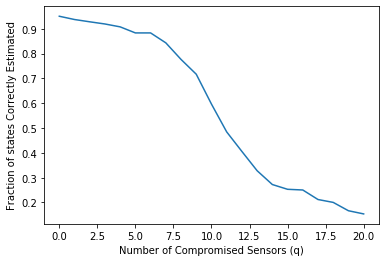

In [4]:
plotting[:] = [i / N for i in plotting]
plt.plot(plotting)
plt.ylabel("Fraction of states Correctly Estimated")
plt.xlabel('Number of Compromised Sensors (q)')
plt.show()